# ***TASK 2***

Description:

"The file 'Parts.csv' contains descriptions of some fictitious parts. Your goal is to find 5 alternative parts to each provided fictitious part in the dataset based on their similarity. First provide descriptive analysis of the data and highlight 2-3 findings and difficulties of the data that we provided and describe how you would handle this. Continue to implement a model that is finding the similar fictitious parts based on the column 'DESCRIPTION'. Please give details of your model and why you choose this. Once you finished your implementation of your chosen model, please think about how you would change or addition your code, when you have more entries and would consider the additional attributes."


### My interpretation of this question

Based on my reading of Task 2, **I interpret this to mean that we should *only* use the column `DESCRIPTION` for this task. Further, I understand that we are being asked to: 1) identify outliers using an outlier detector model; and 2) identify nearest neighbors using a nearest neighbor model**. The wording of this question is unfortunately vague and could be interpreted in different ways, so I want to be up-front about my interpretation.

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KDTree
from sklearn.decomposition import TruncatedSVD

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

## Read data

In [2]:
df = pd.read_csv('./data/parts.csv', sep=';')
print(df.shape)
df.head()

(998, 32)


,ID,DESCRIPTION,Attribut1,Additional Feature,Application,Characteristic,Temp,Height,Length in mm,Rating,Material,Size,Code,Joule-integral-Nom (J),LC Risk,Maximum AC Voltage Rating,Maximum DC Voltage Rating,Maximum Power Dissipation,Mounting,Mounting Feature,Number of Terminals,Operating Temperature-Max (Cel),Operating Temperature-Min (Cel),Physical Dimension,Pre-arcing time-Min (ms),Product Diameter,Product Length,Rated Breaking Capacity (A),Rated Current (A),Rated Voltage (V),Rated Voltage(AC) (V),Rated Voltage(DC) (V)
0,A1,"Indicator Red Fast Movement 1.6A 250V Holder Plastic 5 X 20mm Ceramic Box CCC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 1.6A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,1.6A,Ceramic,5 X 20mm,NaN,0.755J,Low,250V,NaN,4W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,3ms,5.2mm,20mm,1500A,1.6A,250V,250V,NaN
1,A2,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 6.3A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",NaN,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,NaN,Ceramic,5 X 20mm,e2,36.7J,Low,NaN,NaN,NaN,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,3ms,5.2mm,20mm,1500A,6.3A,250V,250V,NaN
2,A3,"Indicator Red Fast Movement 8A 250V Holder Plastic 5 X 20mm Ceramic Box KC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 8A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,8A,Ceramic,5 X 20mm,e2,81.9J,Low,250V,NaN,4W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,1500A,8A,250V,250V,NaN
3,A4,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 10A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",NaN,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,NaN,Ceramic,5 X 20mm,e2,141J,Low,NaN,NaN,NaN,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,1500A,10A,250V,250V,NaN
4,A5,"Indicator Red Fast Movement 12.5A 250V Holder Plastic 5 X 20mm Ceramic Box PSE/cULus Electric Indicator, Very Fast Blow, 12.5A, 250VAC, 500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,12.5A,Ceramic,5 X 20mm,NaN,203J,Low,250V,NaN,6.9(Typ)W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,500A,12.5A,250V,250V,NaN


## Preprocess & EDA

In this section I provide a description analysis of the column `DESCRIPTION` and proceed with preprocessing this field for downstream modeling. I also point out assumptions I make about the data generating process and challenges with using these data for this particular task.

### Missing values in `DESCRIPTION`

To begin, **I assume missingness in this feature is uncorrelated with being an outlier (i.e. a fictitious part); thus I drop all rows with missing data**

In [3]:
df['DESCRIPTION'].isnull().mean()

0.33567134268537074

In [4]:
df = df[df['DESCRIPTION'].notnull()].reset_index(drop=True)
print(df.shape)

(663, 32)


### Duplicates in `DESCRIPTION`

After the above step, we find 81 duplicates in the data (see examples below). **I drop these duplicate observations, assuming that data duplication is unrelated to being an outlier** (i.e. a fictitious part). This simplifies downstream identification of outliers and more importantly identification of related parts.

In [5]:
df['DESCRIPTION'].duplicated().sum()

81

In [6]:
df = df[~df['DESCRIPTION'].duplicated()].reset_index(drop=True)
assert df['DESCRIPTION'].duplicated().sum() == 0

### Variation in description length (according to characters)

Stripping whitespace (but leaving punctuation) from `DESCRIPTION`, we see considerable variation in length according to the number of characters. This ranges from 39 to 179 total characters. **While this suggests the length of descriptions vary, we do not a-priori know whether this relates to being an outlier.**

In [7]:
char = df['DESCRIPTION'].apply(lambda x: len(list(x.replace(' ', ''))))

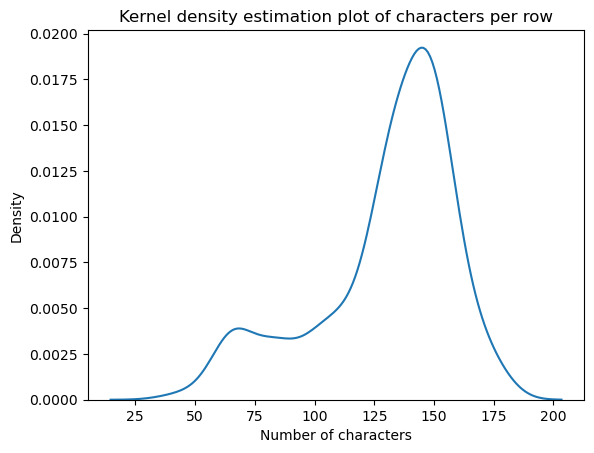

In [8]:
sns.kdeplot(char)
plt.xlabel("Number of characters")
plt.title("Kernel density estimation plot of characters per row")
plt.show()

In [9]:
char.describe()

count    582.000000
mean     129.867698
std       29.000291
min       39.000000
25%      118.250000
50%      137.500000
75%      150.000000
max      179.000000
Name: DESCRIPTION, dtype: float64

### Identifying distinct words & concepts in `DESCRIPTION`

**Identifying distinct word and concepts in these data is especially challenging since the data contain numerous (technical) acronyms, abbreviations, and mathematical measurements (e.g. part length)**

Ideally, we would be provided with information about how the field `DESCRIPTION` is generated, which would allow for better identification of distinct words and concepts. Barring this information - and in the interest of time -, I use a standard text preprocessor, sklearn's `TfidfVectorizer`, and proceed with modeling below. Importantly, however, this reliance on a standard preprocessor will not deliver as good of performance as we would otherwise expect with better engineered (i.e. more manual, with knowledge about the data) preprocessing.

In [10]:
df[['DESCRIPTION']].head()

,DESCRIPTION
0,"Indicator Red Fast Movement 1.6A 250V Holder Plastic 5 X 20mm Ceramic Box CCC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 1.6A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
1,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 6.3A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
2,"Indicator Red Fast Movement 8A 250V Holder Plastic 5 X 20mm Ceramic Box KC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 8A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
3,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 10A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
4,"Indicator Red Fast Movement 12.5A 250V Holder Plastic 5 X 20mm Ceramic Box PSE/cULus Electric Indicator, Very Fast Blow, 12.5A, 250VAC, 500A (IR), Inline/holder, 5x20mm"


### TF-IDF vectorizer for `DESCRIPTION`

`TfidfVectorizer` converts a collection of raw documents to a matrix of TF-IDF features. [Term frequency-inverse document frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic that reflects how important a word is in a document relative to a collection of documents (a corpus). TF-IDF is a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach, where documents are described by word occurrences, while ignoring the relative position of words in a document.

Specifically `TfidfVectorizer`:
- Tokenizes words (i.e. removes whitespace, punctuation, lower cases words, removes stop words)
- Counts the occurrences of tokens in each document
- Normalizes and weights tokens according to their importance

*Importantly* - The number of [ngrams](https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/#:~:text=N%2Dgrams%20are%20continuous%20sequences,(Natural%20Language%20Processing)%20tasks.) dictates the number of unique word concepts in the corpus. As I found in auxilliary analyses, this, in turn, strongly affects the outlier detection model. I select ngrams up to 4 (i.e. unigrams, bigrams, trigrams, quadgrams).

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1, 4))
X_tfidf = tfidf.fit_transform(df['DESCRIPTION'])
print(X_tfidf.shape)

(582, 4378)


## Modeling

#### *The primary difficulty in working with these data is that we are provided no information about how to identify outliers (i.e. fictitious parts)*

Specifically,

- There is no outlier label (i.e. this is an unsupervised task)
- We lack information about what outliers might actually look like
- We lack information about the expected share of outliers in the data

**Unsupervised outlier detection models typically require that the user have some a-priori knowledge about what outliers look like or at least roughly the share of outliers in the data. Since we have neither in this case, I can only assume that the most deviant observations according to the outlier detection model are more likely to be true outliers.**


Given this limitation, I pursue a four-step modeling approach: 
1) Dimensionality reduction of the TF-IDF matrix
2) Outlier detection model
3) Nearest neighbor model all observations
4) Search for nearest neighbors (i.e. alternative parts) for outliers from step #2

Again however, I'm unable to assess how successful these methods are due to this critical missing information.

### Step 1: Dimensionality reduction using truncated SVD (LSA)

I first reduce the dimensionality of the TF-IDF matrix using a truncated singular value decomposition (truncated SVD; also known as latent sentiment analysis [LSA]), which reduces the rank of the matrix and, in expectation, denoises the data. LSA was preferable to PCA given the sparsity of the input matrix.

In [12]:
tsvd = TruncatedSVD(n_components=100, random_state=123)
X_tsvd = tsvd.fit_transform(X_tfidf)
print(tsvd.explained_variance_ratio_.sum())

0.7508040447702822


### Step 2: Outlier detection using isolation forest

Several unsupervised outlier detection models exist (e.g. isolation forest, one class SVM, local outlier factor, robust covariance). Since I'm unable to evaluate the relative performance between these models, I use [isolation forest](https://en.wikipedia.org/wiki/Isolation_forest), which uses binary trees to assign higher anomaly scores to data needing fewer splits for isolation. 

*Note* - in auxilliary analyses I experimented with other outlier detection algorithms. None of these yielded outliers that were any more convincing than isolation forest, so I stuck with the latter.

Not actually knowing the share of outliers, I arbitrarily set the parameter `contamination` to 5% of observations. This works out to about 30 observations in the analytic data set. 

Sklearn's implementation labels anomalous observations as -1, while normal observations are marked as 1.

In [13]:
X = X_tsvd
isof = IsolationForest(random_state=123, contamination=0.05)
pred = pd.Series(isof.fit_predict(X)).rename("pred")
score = pd.Series(isof.decision_function(X)).rename('score')

In [14]:
pred.value_counts(normalize=True)

 1    0.948454
-1    0.051546
Name: pred, dtype: float64

In [15]:
score.describe()

count    582.000000
mean       0.034305
std        0.021513
min       -0.048769
25%        0.018533
50%        0.035685
75%        0.051199
max        0.087321
Name: score, dtype: float64

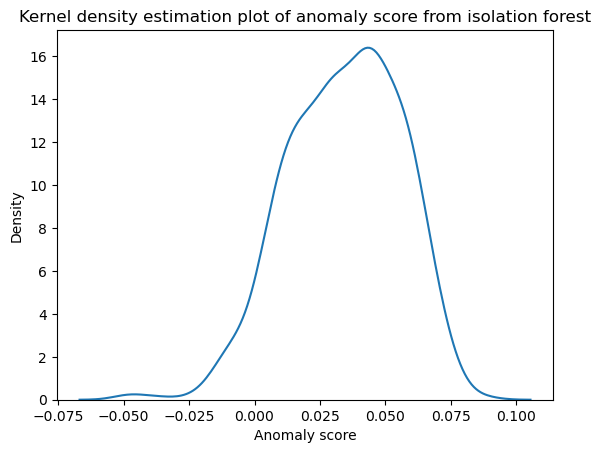

In [16]:
sns.kdeplot(score)
plt.title("Kernel density estimation plot of anomaly score from isolation forest")
plt.xlabel("Anomaly score")
plt.show()

Merging with the original `DESCRIPTION` column and sorting descending by degree of aonomaly, the cell below shows the most anomalous observations according to the model. 

In [17]:
results = pd.concat([df['DESCRIPTION'], pred, score], axis=1)
results.sort_values(by=['score']).head(5)

,DESCRIPTION,pred,score
546,"Indicator Chip Very Fast Movement 0.16A 125V SMD Solder Pad 2410 Ceramic T/R CE/CSA/PSE/UL Electric Indicator, Very Fast Blow, 0.16A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO",-1,-0.048769
496,"Indicator Chip Very Fast Movement 0.16A 125V SMD Solder Pad 2410 Ceramic T/R CSA/UL Electric Indicator, Fast Blow, 0.16A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO",-1,-0.046286
547,"Indicator Chip Very Fast Movement 0.16A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Very Fast Blow, 0.16A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO",-1,-0.036703
311,"Indicator Red Slow Blow Movement 20A 250V Holder Plastic Melf 6.3 X 32mm Ceramic Bulk CE/CSA/PSE/UL/cULus Electric Indicator, Time Lag Blow, 20A, 250VAC, 250VDC, 400A (IR), Inline/holder, 3AB",-1,-0.023109
310,"Indicator Red Slow Blow Movement 20A 250V Axial 6.3 X 32mm Ceramic Bulk CE/CSA/KC/PSE/UL/cULus Electric Indicator, Time Lag Blow, 20A, 250VAC, 250VDC, 400A (IR), Through Hole, 3AB",-1,-0.017913


### Step 3: Nearest neighbor search using k-d trees

A [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) is a space-partitionining data structure in which every node is a k-dimensional point. We use this method to find k nearest neighbors for all observations in the data, including the outliers.

*Note* - I search for nearest neighbors using the truncated SVD matrix, not the TF-IDF matrix. Results, however, were essentially identical.

In [18]:
X = X_tsvd
kdt = KDTree(X)
dist, ind = kdt.query(X, k=10)  # use larger k in case nearest neighbors are also outliers

In [19]:
ind[:, 1:]  # note - first element is observation itself

array([[189, 190,   2, ...,  75,  74, 182],
       [  3,   8,  13, ...,  78,  65, 196],
       [ 75, 184,  68, ...,   0, 288, 217],
       ...,
       [575, 572, 580, ..., 578, 574, 564],
       [573, 577, 572, ..., 578, 575, 489],
       [574, 578, 572, ..., 579, 575, 490]])

### Step 4: Search for alternative parts for outliers

In this step I search for 5 nearest neighbors in `ind` for outliers identified above.

In [20]:
outliers = results[results['pred'] == -1]

In [21]:
outlier_indices = outliers.index.tolist()
max_alternative_parts = 5
output = []
for i in outlier_indices:
    temp = [df.loc[x, 'DESCRIPTION'] for x in ind[i] if x not in outlier_indices]
    output.append(temp[:max_alternative_parts])

In [22]:
alt_parts = pd.concat([df[df.index.isin(outlier_indices)][['DESCRIPTION']], 
                       pd.DataFrame(output, index=outlier_indices, 
                                    columns=[f"alt_{i+1}" for i in range(max_alternative_parts)])], axis=1)

In [23]:
alt_parts

,DESCRIPTION,alt_1,alt_2,alt_3,alt_4,alt_5
9,"Indicator Red Slow Blow Movement 2A 250V Axial 5 X 20mm Ceramic T/R cULus Electric Indicator, Time Lag Blow, 2A, 250VAC, 300VDC, 1500A (IR), Through Hole","Indicator Red Slow Blow Movement 2A 250V Axial 5.4 X 22.5mm Glass Bulk cULus Electric Indicator, Time Lag Blow, 2A, 250VAC, 35A (IR), Through Hole","Indicator Red Slow Blow Movement 2A 250V Holder Plastic Melf 5 X 20mm Ceramic T/R CCC/VDE/cULus Electric Indicator, Time Lag Blow, 2A, 250VAC, 300VDC, 1500A (IR), Surface Mount","Indicator Red Slow Blow Movement 2A 250V Holder Plastic Melf 5 X 20mm Ceramic Bag CCC/VDE/cULus Electric Indicator, Time Lag Blow, 2A, 250VAC, 300VDC, 1500A (IR), Surface Mount","Indicator Red Slow Blow Movement 2A 250V Holder Plastic 6.3 X 32mm Glass Box CSA Electric Indicator, Time Lag Blow, 2A, 250VAC, 35A (IR), Inline/holder","Indicators PN Electric Indicator, Time Lag Blow, 2A, 250VAC, 300VDC, 1500A (IR), Surface Mount"
14,"Non Resettable Indicators Electric Indicator, Time Lag Blow, 5A, 250VAC, 150VDC, 1500A (IR), Inline/holder, 5x20mm","Non Resettable Indicators Electric Indicator, Time Lag Blow, 4A, 250VAC, 150VDC, 1500A (IR), Inline/holder, 5x20mm","Non Resettable Indicators Electric Indicator, Very Fast Blow, 10A, 250VAC, 1500A (IR), Inline/holder, 5x20mm","Non Resettable Indicators Electric Indicator, Very Fast Blow, 6.3A, 250VAC, 1500A (IR), Inline/holder, 5x20mm","Non Resettable Indicators Electric Indicator, Time Lag Blow, 2A, 250VAC, 300VDC, 1500A (IR), Inline/holder, 5x20mm","Indicator Misc, Non resettable Indicators, Red Indicators, Typ FTT 5x20 Indicator"
17,"Indicator Red Slow Blow Movement 16A 250V Holder Plastic 5 X 20mm Ceramic Box CCC/CSA/PSE/UL/VDE/cULus Electric Indicator, Time Lag Blow, 16A, 250VAC, 125VDC, 500A (IR), Inline/holder, 5x20mm","Indicator Red Slow Blow Movement 16A 250V Holder Plastic 5 X 20mm Glass Box PSE/VDE/cULus Electric Indicator, Time Lag Blow, 16A, 250VAC, 160A (IR), L, Inline/holder, 5x20mm","Indicator Red Slow Blow Movement 16A 250V Holder Plastic 6.3 X 32mm Glass Box UL Electric Indicator, Time Lag Blow, 16A, 250VAC, 1000A (IR), H, Inline/holder",Indicator Holder 16A 250VAC Solder Lug Through Hole Box ROTARY SWITCH-,"Indicator SubRed Slow Blow Movement 0.1A 250V Radial 8.5 X 8.5mm Thermoplastic Bag CCC/CSA/PSE/UL/VDE/cULus Electric Indicator, Time Lag Blow, 0.1A, 250VAC, 125VDC, 35A (IR), Through Hole","Indicator Red Slow Blow Movement 1A 250V Holder Plastic Melf 5 X 20mm Ceramic Box CCC/CSA/PSE/VDE/cULus Electric Indicator, Time Lag Blow, 1A, 250VAC, 300VDC, 1500A (IR), Inline/holder, 5x20mm"
46,"Indicators PN Electric Indicator, Time Lag Blow, 8A, 250VAC, 150VDC, 1000A (IR), Surface Mount","Indicators PN Electric Indicator, Time Lag Blow, 10A, 250VAC, 150VDC, 1000A (IR), Surface Mount","Indicator Red Slow Blow Movement 8A 250V Holder Plastic Melf 5 X 20mm Ceramic Bulk KC/PSE/VDE/cULus Electric Indicator, Time Lag Blow, 8A, 250VAC, 150VDC, 1000A (IR), Inline/holder, 5x20mm","Indicator Red Slow Blow Movement 8A 250V Holder Plastic Melf 5 X 20mm Ceramic T/R CCC/VDE/cULus Electric Indicator, Time Lag Blow, 8A, 250VAC, 150VDC, 1000A (IR), Surface Mount","Indicator Red Slow Blow Movement 8A 250V Holder Plastic Melf 5 X 20mm Ceramic Bag CCC/VDE/cULus Electric Indicator, Time Lag Blow, 8A, 250VAC, 150VDC, 1000A (IR), Surface Mount","Indicators PN Electric Indicator, Time Lag Blow, 5A, 250VAC, 150VDC, 1500A (IR), Surface Mount"
52,"Indicator Red Slow Blow Movement 12.5A 250V Holder Plastic Melf 5 X 20mm Ceramic T/R CCC/VDE/cULus Electric Indicator, Time Lag Blow, 12.5A, 250VAC, 125VDC, 500A (IR), Surface Mount","Indicator Red Slow Blow Movement 12.5A 250V Holder Plastic Melf 5 X 20mm Ceramic Bag CCC/VDE/cULus Electric Indicator, Time Lag Blow, 12.5A, 250VAC, 125VDC, 500A (IR), Surface Mount","Indicator Red Fast Movement 12.5A 250V Holder Plastic 5 X 20mm Ceramic Bulk PSE/cULus Electric Indicator, Very Fast Blow, 12.5A, 250VAC, 500A (IR), Inline/holder, 5x20mm","Ind